In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler, random_split
import timeit
import math
import pickle

from sklearn.metrics import confusion_matrix

## 1. Data preprocessing

### 1.1 read data

In [2]:
defaultVal = [[0.] for idx in range(2*3 + 1)]
print(defaultVal)

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


In [3]:
# get the data of the subject and returns df with the relevant information
def prep_data(path, subject):
    data = pd.read_csv(path, sep=' ', header=None)
    data.columns = pd.RangeIndex(1, len(data.columns) + 1) 
    data.drop(3, axis='columns', inplace=True)
    data = data.dropna()
    data = data[[1,2,22,23,24,28,29,30]]
    cols = {1: 'time_step', 2: 'activity_id', 22: 'acc_x', 23: 'acc_y', 24: 'acc_z', 28: 'gyro_x', 29: 'gyro_y', 30: 'gyro_z'}
    data = data.rename(columns=cols)
    # calculating norm
    data['acc_norm'] = np.sqrt(data['acc_x'] ** 2 + data['acc_y'] ** 2 + data['acc_z'] ** 2)
    data['gyro_norm'] = np.sqrt(data['gyro_x'] ** 2 + data['gyro_y'] ** 2 + data['gyro_z'] ** 2)
    data['User'] = f'{subject}'
    print(f'{subject}')
    return data

In [4]:
# data = pd.read_csv('/Users/momo/Documents/dataset/pamap2+physical+activity+monitoring/Protocol/subject101.dat', sep=' ', header=None)
# data.head()

In [5]:
# Perform preprocess for different subjects
# subjects = ['101', '102', '105', '106', '107', '108']
subjects = ['101','102']
path = '/Users/momo/Documents/dataset/pamap2+physical+activity+monitoring/Protocol'
data_list = []
for subject in subjects:
    data_list.append(prep_data(path + '/subject' + subject + '.dat', subject))

101
102


In [6]:
data_list[0].head(),data_list[1].head()

(   time_step  activity_id     acc_x    acc_y    acc_z    gyro_x    gyro_y  \
 0       8.38            0  0.238080  9.80003 -1.68896 -0.005065 -0.006781   
 1       8.39            0  0.319530  9.61282 -1.49328  0.013685  0.001486   
 2       8.40            0  0.235593  9.72421 -1.76621 -0.039923  0.034056   
 3       8.41            0  0.388697  9.53572 -1.72410  0.007513 -0.010498   
 4       8.42            0  0.315800  9.49908 -1.60914 -0.003822 -0.011217   
 
      gyro_z  acc_norm  gyro_norm User  
 0 -0.005663  9.947354   0.010184  101  
 1 -0.041522  9.733360   0.043744  101  
 2 -0.002113  9.886115   0.052518  101  
 3 -0.020684  9.698122   0.024382  101  
 4 -0.025975  9.639584   0.028550  101  ,
    time_step  activity_id    acc_x    acc_y    acc_z    gyro_x    gyro_y  \
 0       5.64            0  1.94739  9.59644 -3.12873  0.124025  0.112482   
 1       5.65            0  1.75120  9.63340 -3.32601  0.132679  0.060829   
 2       5.66            0  1.67059  9.70790 -3.4826

In [7]:
# Combine to one df
for d in range(len(data_list)):
  if d==0:
    df = data_list[0]
  else:
    df = pd.concat([df, data_list[d]], axis=0, ignore_index=True)

### 1.2 normalization

In [8]:
def normalize(df, cols): #list of columns
    df_t=(df[cols]-df[cols].mean())/df[cols].std() #均值为0，方差为1的分布
    df_norm = df.copy()
    df_norm[cols] = df_t

    return df_norm

In [9]:
data_norm = normalize(df, ['acc_norm', 'gyro_norm'])

### 1.3 augmentation

In [10]:
def add_noise(df, cols, sigma=0.1):
    noise = np.random.normal(0, sigma, df[cols].shape)
    new_signal = df[cols] + noise
    df_noise = df.copy()
    df_noise[cols] = new_signal

    return df_noise

def augment(df, cols, num_of_inst):
    '''
    df should be inserted normalized
    num_of_inst = num of instances to create from each instance
    '''
    aug_df = df.copy()
    for i in range(num_of_inst):
        np.random.seed(i)
        nois_data = add_noise(df, cols)
        nois_data['User'] = nois_data['User'] + f'{i}'
        aug_df= pd.concat([aug_df, nois_data], axis=0, ignore_index=True)

    return aug_df

In [11]:
data_aug = augment(data_norm, ['acc_norm', 'gyro_norm'], 1)

In [12]:
data_aug.head()

,time_step,activity_id,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,acc_norm,gyro_norm,User
0,8.38,0,0.238080,9.80003,-1.68896,-0.005065,-0.006781,-0.005663,-0.066101,-0.818660,101
1,8.39,0,0.319530,9.61282,-1.49328,0.013685,0.001486,-0.041522,-0.128133,-0.764882,101
2,8.40,0,0.235593,9.72421,-1.76621,-0.039923,0.034056,-0.002113,-0.083853,-0.750823,101
3,8.41,0,0.388697,9.53572,-1.72410,0.007513,-0.010498,-0.020684,-0.138347,-0.795908,101
4,8.42,0,0.315800,9.49908,-1.60914,-0.003822,-0.011217,-0.025975,-0.155316,-0.789230,101


### 1.4 FFT

In [13]:
aaa = data_aug
np.unique(aaa['activity_id'])
np.unique(aaa['User'])

array(['101', '1010', '102', '1020'], dtype=object)

In [14]:
initial_data = data_aug
unique_actions = np.unique(initial_data['activity_id'])
unique_users = np.unique(initial_data['User'])
dff = pd.DataFrame(columns=['activity','timstep', 'user','acc_spec','gyro_spec'])
print(dff.shape)
dff.head()

(0, 5)


,activity,timstep,user,acc_spec,gyro_spec


In [15]:
print(unique_actions)

[ 0  1  2  3  4  5  6  7 12 13 16 17 24]


In [16]:
path = '/Users/momo/Desktop'
for action in [1]:
    print('action: ', action)
    for user in ['101']:
        print('user: ', user)
        act_user_temp = initial_data[(initial_data['activity_id']==action) & (initial_data['User']==user)]
        NFFT = 25
        noverlap = int(0.25 * NFFT)
        print(act_user_temp.shape, noverlap)
        fig = plt.figure(frameon=False)
        sr = 100
        timestep = 0
        for row in range(0, act_user_temp.shape[0], 150): # overlap of the data is 50%. not the hyperparameter of FFT.
            timestep += 1
            spec_acc, freqenciesFound_x, time, imageAxis_x = plt.specgram(act_user_temp['acc_norm'][row:row + 200], Fs=100, NFFT=NFFT, noverlap=noverlap, window=np.hamming(NFFT),cmap='viridis')
            spec_gyro, freqenciesFound_x, time, imageAxis_x = plt.specgram(act_user_temp['gyro_norm'][row:row + 200], Fs=100, NFFT=NFFT, noverlap=noverlap, window=np.hamming(NFFT),cmap='viridis')
            instance = pd.DataFrame({'activity':action, 'timstep':timestep, 'user':user, 'acc_spec':[spec_acc], 'gyro_spec':[spec_gyro]})
            dff = dff.append(instance, ignore_index=True) # label, timestep, user, f*t (spectrogram), f*t (spectrogram)
        plt.close("all")

action:  1
user:  101
(27179, 11) 6


In [ ]:
# dff.to_pickle(path+"/labeled_data.pkl")

In [18]:
df = pd.read_pickle(path+"/labeled_data.pkl")

### 1.5 filtering targeted activities and making the labels sequencials

In [19]:
df = df[df['activity'].isin([1,2,3,4,5,6,7,12,13,16,17])]
df['activity'].loc[(df['activity']==12)] = 8
df['activity'].loc[(df['activity']==13)] = 9
df['activity'].loc[(df['activity']==16)] = 10
df['activity'].loc[(df['activity']==17)] = 0
df[df['activity'] == 10].shape

(0, 5)

In [29]:
df0 =  df[df['activity']==0]
df0_100 = df0.reset_index().iloc[:1000]

df1 =  df[df['activity']==1]
df1_100 = df1.reset_index().iloc[:1000]

df2 =  df[df['activity']==2]
df2_100 = df2.reset_index().iloc[:1000]

df3 =  df[df['activity']==3]
df3_100 = df3.reset_index().iloc[:1000]

df4 =  df[df['activity']==4]
df4_100 = df4.reset_index().iloc[:1000]

df5 =  df[df['activity']==5]
df5_100 = df5.reset_index().iloc[:1000]

df6 =  df[df['activity']==6]
df6_100 = df6.reset_index().iloc[:1000]

df7 =  df[df['activity']==7]
df7_100 = df7.reset_index().iloc[:1000]

In [30]:
df = pd.concat([df0_100, df1_100, df2_100, df3_100,df4_100,df5_100,df6_100,df7_100])

In [31]:
loader_df = pd.DataFrame(columns=['id', 'input_5_timesteps', 'label'])
id = 0
for user in unique_users:
    for action in unique_actions:
        ua_df = df[(df['user']==user) & (df['activity']==action)]
        for t in range(0, ua_df.shape[0], 5):
          vec_acc = ua_df.iloc[t:t+5]['acc_spec'].tolist()
          vec_gyro = ua_df.iloc[t:t+5]['gyro_spec'].tolist()
          vec_acc_gyro = [vec_acc] + [vec_gyro]
          instance = pd.DataFrame({'id': id, 'input_5_timesteps': [vec_acc_gyro], 'label': action})
          loader_df = loader_df.append(instance, ignore_index=True)
          id += 1

In [32]:
x = loader_df['input_5_timesteps']
id = []
label = []
tensor_input = []

for i in range(len(x)):
  try:
    x_tensor = torch.FloatTensor(x[i])
    # print(x_tensor.shape)
    if x_tensor.shape == torch.Size([2, 5, 13, 10]):
      tensor_input.append(x_tensor)
      label.append(loader_df['label'][i])
      id.append(loader_df['id'][i])

  except:
    print('*********',i)

********* 36


/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/607291761.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/torch/csrc/utils/tensor_new.cpp:201.)
  x_tensor = torch.FloatTensor(x[i])


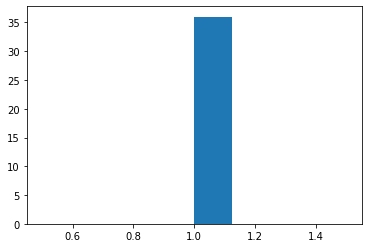

In [33]:
plt.hist(label, bins=8);

In [34]:
len(id), len(label), len(tensor_input)

(36, 36, 36)

In [35]:
np.unique(label, return_counts=True)

(array([1]), array([36]))

### Dataloader

In [36]:
id = torch.tensor(id)
label = torch.tensor(label)
tensor_input = torch.stack(tensor_input)

In [39]:
dataset = TensorDataset(id, tensor_input, label)
train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

28 training samples
8 validation samples


In [40]:
torch.manual_seed(0)
batch_size = 1
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
            )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
            )

## Network

torch.Size([13, 10])

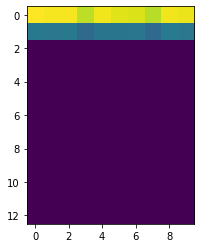

In [41]:
instance = next(iter(train_dataloader))
acc_inst = instance[1][0][0][0]
gyro_inst = instance[1][0][1][0]
plt.imshow(gyro_inst);
acc_inst.shape

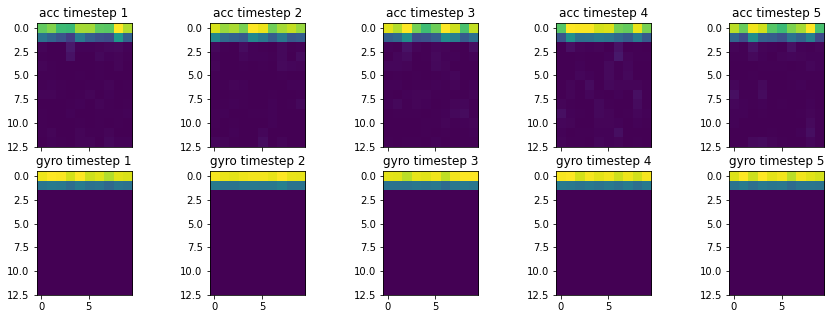

In [42]:
fig, axes = plt.subplots(2, 5, sharex=True, sharey=False, figsize=(15,5))
instance = next(iter(train_dataloader))
for i in range(5):
    axes[0,i].imshow(instance[1][0][0][i])
    axes[0,i].set_title(f'acc timestep {i+1}')
for i in range(5):
    axes[1,i].imshow(instance[1][0][1][i])
    axes[1,i].set_title(f'gyro timestep {i+1}')

In [43]:
torch.manual_seed(0)
class CNN_acc(nn.Module):
  def __init__(self):
    super(CNN_acc, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, (1,3), padding='same')
    self.conv2 = nn.Conv2d(32, 32, (1,3), padding='same')
    self.conv3 = nn.Conv2d(32, 64, (1,3), padding='same')
    self.conv4 = nn.Conv2d(64, 64, (1,3), padding='same')
    self.fc = nn.Linear(2048, 128)
    torch.nn.init.xavier_normal(self.fc.weight)
    torch.nn.init.xavier_normal(self.conv1.weight)
    torch.nn.init.xavier_normal(self.conv2.weight)
    torch.nn.init.xavier_normal(self.conv3.weight)
    torch.nn.init.xavier_normal(self.conv4.weight)


  def forward(self, x):
    # print('x.shape 1: ', x.shape)
    x = F.relu(self.conv1(x))
    # print('x.shape 2: ', x.shape)
    x = F.relu(F.max_pool2d(self.conv2(x), (1,2)))
    # print('x.shape 3: ', x.shape)
    x = F.relu(self.conv3(x))
    # print('x.shape 4: ', x.shape)
    x = F.relu(F.max_pool2d(self.conv4(x), (1,2)))
    # print('x.shape 5: ', x.shape)
    x = torch.flatten(x, start_dim=1)
    # print('x.shape 6: ', x.shape)
    x = self.fc(x)
    # print('x.shape 7: ', x.shape)

    return x

In [44]:
torch.manual_seed(0)
class CNN_gyro(nn.Module):
  def __init__(self):
    super(CNN_gyro, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, (1,3), padding='same')
    self.conv2 = nn.Conv2d(32, 32, (1,3), padding='same')
    self.conv3 = nn.Conv2d(32, 64, (1,3), padding='same')
    self.conv4 = nn.Conv2d(64, 64, (1,3), padding='same')
    self.fc = nn.Linear(2048, 128)
    torch.nn.init.xavier_normal(self.fc.weight)
    torch.nn.init.xavier_normal(self.conv1.weight)
    torch.nn.init.xavier_normal(self.conv2.weight)
    torch.nn.init.xavier_normal(self.conv3.weight)
    torch.nn.init.xavier_normal(self.conv4.weight)

  def forward(self, x):
    # print('x.shape 1: ', x.shape)
    x = F.relu(self.conv1(x))
    # print('x.shape 2: ', x.shape)
    x = F.relu(F.max_pool2d(self.conv2(x), (1,2)))
    # print('x.shape 3: ', x.shape)
    x = F.relu(self.conv3(x))
    # print('x.shape 4: ', x.shape)
    x = F.relu(F.max_pool2d(self.conv4(x), (1,2)))
    # print('x.shape 5: ', x.shape)
    x = torch.flatten(x, start_dim=1)
    # print('x.shape 6: ', x.shape)
    x = self.fc(x)

    return x

In [45]:
class Attention2(nn.Module):
  def __init__(self):
    super(Attention2, self).__init__()
    self.w = torch.rand(5, 1)
    self.w = torch.nn.Parameter(torch.nn.init.xavier_uniform_(self.w))
    self.b = torch.zeros(1)
    self.b = torch.nn.Parameter(self.b)
    self.v = torch.rand(64, 1)
    self.v = torch.nn.Parameter(torch.nn.init.xavier_uniform_(self.v))
    self.new_linear = torch.nn.Linear(64, 64)

  def forward(self, x):
    # print('x.shape: ', x.shape)
    temp_o = self.new_linear(torch.squeeze(x, 1))
    # print('temp_o.shape: ', temp_o.shape)
    o = torch.tanh(temp_o)
    # print('temp_o.shape: ', temp_o.shape)
    temp_w = o @ self.v
    # print('temp_w.shape: ', temp_w.shape)
    w = F.softmax(temp_w)
    # print('w.shape: ', w.shape)
    context = w.T @ temp_o
    # print('context.shape: ',context.shape)
    
    return context

In [46]:
class Attnsense(nn.Module):
  def __init__(self):
    super(Attnsense, self).__init__()
    self.conv_acc = CNN_acc()
    self.conv_gyro = CNN_gyro()
    self.attn1 = torch.nn.MultiheadAttention(128, 1, batch_first=True)
    self.attn2 = Attention2()
    self.gru = nn.GRU(128, 64, num_layers=2)
    self.fc_gru = nn.Linear(64, 8)


  def forward(self, x):
    # print(x[0][0].shape)
    acc_input = x[0][0].reshape(5,1,1,130)
    gyro_input = x[0][1].reshape(5,1,1,130)
    conv_acc_out = self.conv_acc.forward(acc_input)
    conv_gyro_out = self.conv_gyro.forward(gyro_input)
    # print('conv_acc_out: ', conv_acc_out.shape)
    zipped = torch.stack([conv_acc_out, conv_gyro_out], dim=1)
    # print('zipped.shape: ', zipped.shape)
    attn1_out = self.attn1(zipped, zipped, zipped)[0][:,0,:]
    # print('attn1_out.shape: ', attn1_out.shape)
    out_gru = self.gru(attn1_out.unsqueeze(1))[0]
    # print('out_gru: ', out_gru.shape)
    out_attn2 = self.attn2(out_gru)
    # print('out_attn2: ', out_attn2.shape)
    x = self.fc_gru(out_attn2)
    # # print('x.shape: ', x.shape)
    x = F.softmax(x, dim=1)

    return x

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
def loss_calc(net, loader, criterion):
  with torch.no_grad():
    tot_loss = 0
    for i, data in enumerate(loader, 0):
      _, inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      tot_loss += loss.item()
      
  return tot_loss / (i + 1)

In [49]:
def save_vectors(vectors, name):
    a_file = open(f'{name}.pkl', 'wb')
    pickle.dump(vectors, a_file)
    a_file.close()

In [52]:
torch.manual_seed(0)

def train(net, train_loader, test_loader, epochs):
    lowest_loss = 0
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum=0.9) # best learning rate was 0.00005
    start_time = timeit.default_timer()
    train_loss = {}
    test_loss = {}
    for epoch in range(epochs):
        running_loss = 0.0
        print(epoch)
        for i, data in enumerate(train_loader, 0):
            _, inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device) 

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 100 == 0:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        train_loss[epoch + 1] = loss_calc(net, train_loader, criterion)

        test_loss[epoch + 1] = loss_calc(net, test_loader, criterion) 
        print(f'Epoch = {epoch + 1}, train loss = {train_loss[epoch + 1]}')
        print(f'Epoch = {epoch + 1}, test loss = {test_loss[epoch + 1]}')
        if test_loss[epoch + 1] < 1.7 and lowest_loss == 0:
          lowest_loss = test_loss[epoch + 1]
          torch.save(net.state_dict(), path+'/model_with_attentions10')
          save_vectors(train_loss, path+'/train_loss_attention10')
          save_vectors(test_loss, path+'/test_loss_attention10')
        if test_loss[epoch + 1] < lowest_loss:
          lowest_loss = test_loss[epoch + 1]
          torch.save(net.state_dict(), path+'/model_with_attentions10')
          save_vectors(train_loss, path+'/train_loss_attention10')
          save_vectors(test_loss, path+'/test_loss_attention10')
    end_time = timeit.default_timer()

    print(f'Finish Training + Testing after: {end_time - start_time}')
    return train_loss, test_loss

In [53]:
net = Attnsense().to(device)

/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.fc.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.conv1.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:12: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.conv2.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:13: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.conv3.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:14: UserWarning: nn.init.xavier_normal i

In [54]:
train_loss, test_loss = train(net, train_dataloader, validation_dataloader, 10)

0


/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/1871628809.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  w = F.softmax(temp_w)


Epoch = 1, train loss = 2.10515981061118
Epoch = 1, test loss = 2.1051613986492157
1
Epoch = 2, train loss = 2.096319760595049
Epoch = 2, test loss = 2.096321403980255
2
Epoch = 3, train loss = 2.0859190225601196
Epoch = 3, test loss = 2.0859207808971405
3
Epoch = 4, train loss = 2.0737067631312778
Epoch = 4, test loss = 2.0737085044384003
4
Epoch = 5, train loss = 2.059223634856088
Epoch = 5, test loss = 2.0592255294322968
5
Epoch = 6, train loss = 2.0418530702590942
Epoch = 6, test loss = 2.0418550074100494
6
Epoch = 7, train loss = 2.0207707371030534
Epoch = 7, test loss = 2.020772874355316
7
Epoch = 8, train loss = 1.994878615651812
Epoch = 8, test loss = 1.994880810379982
8
Epoch = 9, train loss = 1.9627410641738348
Epoch = 9, test loss = 1.9627432972192764
9
Epoch = 10, train loss = 1.9225727702890123
Epoch = 10, test loss = 1.9225750416517258
Finish Training + Testing after: 5.21711966700002


In [55]:
net = Attnsense()
print(net.forward)

<bound method Attnsense.forward of Attnsense(
  (conv_acc): CNN_acc(
    (conv1): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv3): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv4): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (fc): Linear(in_features=2048, out_features=128, bias=True)
  )
  (conv_gyro): CNN_gyro(
    (conv1): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv3): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv4): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (fc): Linear(in_features=2048, out_features=128, bias=True)
  )
  (attn1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (attn2): Attention2(
    

/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.fc.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.conv1.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:12: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.conv2.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:13: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.conv3.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:14: UserWarning: nn.init.xavier_normal i

### Evaluation

In [56]:
def load_vectors(path):
    t = open(path, 'rb')
    output = pickle.load(t)
    t.close()
    
    return output

In [57]:
min(test_loss.values())

1.9225750416517258

In [58]:
def mean_k(dict_values, k):
    val = np.array(list(dict_values))
    out = []
    for i in range(val.shape[0] - k):
      out.append(val[i:i+k].mean())
    return out

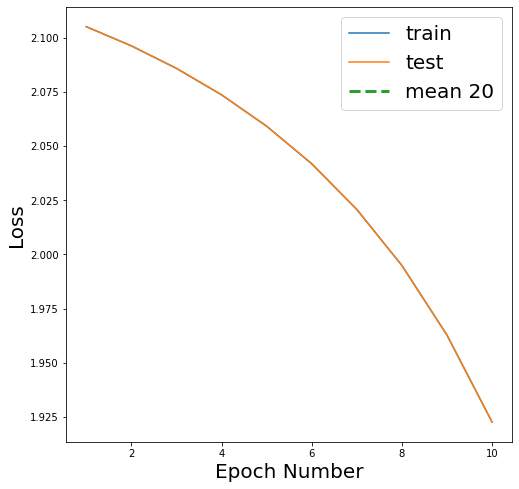

In [59]:
plt.figure(figsize = (8, 8))
plt.plot(list(train_loss.keys()), list(train_loss.values()), label = 'train')
plt.plot(list(test_loss.keys()), list(test_loss.values()), label = 'test')
plt.plot(mean_k(train_loss.values(), 20), label = 'mean 20', linewidth=3, linestyle='--')
plt.xlabel('Epoch Number', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.legend(fontsize = 20)

In [61]:
model = Attnsense()
model.load_state_dict(torch.load(path+'/model_with_attentions10'))

/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.fc.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.conv1.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:12: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.conv2.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:13: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.conv3.weight)
/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_83676/2345605162.py:14: UserWarning: nn.init.xavier_normal i

FileNotFoundError: [Errno 2] No such file or directory: '/Users/momo/Desktop/model_with_attentions10'

In [ ]:
def acc(net, loader):
    correct = 0
    total = 0
    all_preds = torch.tensor([])
    all_lab = torch.tensor([])
    with torch.no_grad():
        for data in loader:
            _, inputs, labels = data
            inputs = inputs
            labels = labels
            outputs = net(inputs).reshape(1,-1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds = torch.cat((all_preds, predicted) ,dim=0)
            all_lab = torch.cat((all_lab, labels) ,dim=0)
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    return all_lab, all_preds

In [ ]:
y_true, y_pred = acc(model, validation_dataloader)

NameError: name 'model' is not defined

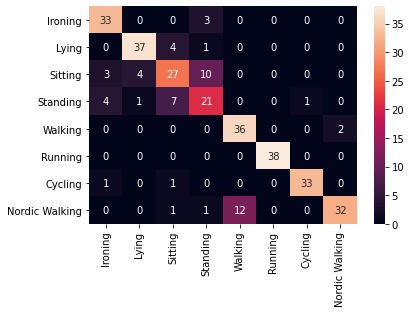

In [ ]:
activities = ['Ironing', 'Lying', 'Sitting', 'Standing', 'Walking', 'Running', 'Cycling', 'Nordic Walking']
sn.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred), columns=activities, index=activities), annot=True)

## 2. Model

In [20]:
SEPCTURAL_SAMPLES = 10
FEATURE_DIM = SEPCTURAL_SAMPLES*6*2
CONV_LEN = 3
CONV_LEN_INTE = 3#4
CONV_LEN_LAST = 3#5
CONV_NUM = 64
CONV_MERGE_LEN = 8
CONV_MERGE_LEN2 = 6
CONV_MERGE_LEN3 = 4
CONV_NUM2 = 64
INTER_DIM = 120
OUT_DIM = 6#len(idDict)
WIDE = 20
CONV_KEEP_PROB = 0.8

BATCH_SIZE = 64
TOTAL_ITER_NUM = 30000

select = 'a'

metaDict = {'a':[119080, 1193], 'b':[116870, 1413], 'c':[116020, 1477]}
TRAIN_SIZE = metaDict[select][0]
EVAL_DATA_SIZE = metaDict[select][1]
EVAL_ITER_NUM = int(math.ceil(EVAL_DATA_SIZE / BATCH_SIZE))

In [21]:
#Example usage: batch_norm_layer = BatchNormLayer(num_features=32, eps=1e-5, momentum=0.1)
#               output = batch_norm_layer(input_tensor, phase_train)

class BatchNormLayer(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNormLayer, self).__init__()
        self.eps = eps
        self.momentum = momentum
        self.bn = nn.BatchNorm2d(num_features, eps=self.eps, momentum=self.momentum)

    def forward(self, inputs, phase_train):
        if phase_train: #True for training, and False for evaluation
            return self.bn(inputs)
        else:
            return self.bn(inputs)

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding='valid'):
        super(Conv, self).__init__()
        if padding == 'valid':
            self.padding = 0
        elif padding == 'same':
            self.padding = (kernel_size - 1) // 2
        else:
            raise ValueError("Invalid padding mode. Use 'valid' or 'same'.")
            
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=self.padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout2d(p=1-CONV_KEEP_PROB),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=self.padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout2d(p=1-CONV_KEEP_PROB),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=self.padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, inputs):
        print('x.shape 1: ', inputs.shape)
        x = self.conv1(inputs)
        print('x.shape 2: ', x.shape)
        x = self.conv2(x)
        print('x.shape 3: ', x.shape)
        x = self.conv3(x)
        print('x.shape 4: ', x.shape)
        x = torch.flatten(x, start_dim=1)
        print('x.shape 5: ', x.shape)
        x = self.fc(x)
        print('x.shape 6: ', x.shape)
        return x

In [22]:
def conv(inputs, name, train):
    # CONV_NUM is 64
    conv1 = nn.Conv2d(inputs.size(1), CONV_NUM, kernel_size=(1, 2*3*CONV_LEN), stride=(1, 2*3), padding=0)
    conv1 = nn.BatchNorm2d(CONV_NUM)
    conv1_shape = conv1(inputs).size()
    print("conv1 ", conv1_shape)
    conv1 = nn.ReLU(inplace=True)
    conv1 = nn.Dropout2d(p=1-CONV_KEEP_PROB)(conv1(inputs))

    # CONV_LEN_INTE is 3
    conv2 = nn.Conv2d(CONV_NUM, CONV_NUM, kernel_size=(1, CONV_LEN_INTE), stride=(1, 1), padding=0)
    conv2 = nn.BatchNorm2d(CONV_NUM)
    conv2_shape = conv2(conv1).size()
    print("conv2 ", conv2_shape)
    conv2 = nn.ReLU(inplace=True)
    conv2 = nn.Dropout2d(p=1-CONV_KEEP_PROB)(conv2(conv1))

    # CONV_LEN_LAST is 3
    conv3 = nn.Conv2d(CONV_NUM, CONV_NUM, kernel_size=(1, CONV_LEN_LAST), stride=(1, 1), padding=0)
    conv3 = nn.BatchNorm2d(CONV_NUM)
    conv3_shape = conv3(conv2).size()
    print("conv3 ", conv3_shape)

    conv_out = conv3.view(conv3_shape[0], conv3_shape[1], 1, conv3_shape[2], conv3_shape[3])
    return conv_out


In [ ]:
inputs= np.ones(120).reshape([2, 3, 4, 5])
inputs = torch.from_numpy(inputs)
inputs

In [23]:
def attention_mode(inputs): # Attention-fusion Subnet
    """inputs, shape: [batch, time_step, input_mode, feature_dim]"""
    d = inputs.shape[-1]
    l = inputs.shape[-2]
    print(d,l)
    w = torch.randn([d,l], requires_grad=True, dtype=torch.double) * 0.1 # weights
    b = torch.randn(l, requires_grad=True, dtype=torch.double) * 0.1 
    omega = torch.randn(l, requires_grad=True, dtype=torch.double) * 0.1 

    activation = torch.tanh(torch.matmul(inputs,w) + b)  # b * t * i * i = [b,t,i,d] * [d,i]
    activation = torch.matmul(activation,omega) # b * t * i = [b,t,i,i] * [i]
    alphas = F.softmax(activation, dim=-1)  # b * t * i
    print("alphas ", str(alphas.shape))
    beta = inputs * alphas.unsqueeze(-1)
    print(beta.shape)
    output = torch.sum(beta, dim=2)  # b * t * d = [b,t,i,d] * [b,t,i,1] element_wise
    print(output.shape) #shape: [batch, time_step, feature_dim]
    return alphas, output

In [26]:
def attention_time(inputs, attention_size, time_major=False, return_alphas=False):
    if isinstance(inputs, tuple):
        # In case of Bi-RNN, concatenate the forward and the backward RNN outputs.
        inputs = torch.cat(inputs, 2)

    if time_major:
        # (T,B,D) => (B,T,D)
        inputs = inputs.transpose(0, 1)

    hidden_size = inputs.size(2)  # D value - hidden size of the RNN layer

    # Trainable parameters
    w_omega = nn.Parameter(torch.randn(hidden_size, attention_size) * 0.1)
    b_omega = nn.Parameter(torch.randn(attention_size) * 0.1)
    u_omega = nn.Parameter(torch.randn(attention_size) * 0.1)

    with torch.no_grad():
        w_omega.requiresGrad = True
        b_omega.requiresGrad = True
        u_omega.requiresGrad = True

    with torch.name_scope('v'):
        # Applying fully connected layer with non-linear activation to each of the B*T timestamps;
        # the shape of `v` is (B,T,D)*(D,A)=(B,T,A), where A=attention_size
        v = torch.tanh(torch.matmul(inputs, w_omega) + b_omega)

    # For each of the timestamps, its vector of size A from `v` is reduced with the `u` vector
    vu = torch.matmul(v, u_omega).squeeze(-1)  # (B,T) shape
    alphas = F.softmax(vu, dim=1)   # (B,T) shape

    # Output of (Bi-)RNN is reduced with the attention vector; the result has (B,D) shape
    output = torch.sum(inputs * alphas.unsqueeze(-1), dim=1)

    if not return_alphas:
        return output
    else:
        return output, alphas


In [28]:
class AttnSense(nn.Module):
    def __init__(self):
        super(AttnSense, self).__init__()
        self.used = None
        self.avgNum = None

        self.attn1 = attention_mode()
        self.attn2 = attention_time()
        self.conv = Conv()

        # Define GRU layer
        self.gru1 = nn.GRUCell(input_size, hidden_size)
        self.gru2 = nn.GRUCell(hidden_size, hidden_size)
        self.fc_gru = nn.

        self.cell = nn.RNNCellBase([self.gru1, self.gru2])
        self.init_state = torch.zeros(2, BATCH_SIZE, hidden_size, dtype=torch.float32)

        self.AZ = 80
        self.attention_out = None

    def forward(self, inputs):
        used = torch.sign(torch.max(torch.abs(inputs), dim=2)[0])  # (BATCH_SIZE, WIDE)
        self.used = used
        length = torch.sum(used, dim=1)  # (BATCH_SIZE)
        length = length.type(torch.int64)

        mask = torch.sign(torch.max(torch.abs(inputs), dim=2, keepdim=True)[0])
        mask = mask.repeat(1, 1, INTER_DIM)  # (BATCH_SIZE, WIDE, INTER_DIM)
        avgNum = torch.sum(mask, dim=1)  # (BATCH_SIZE, INTER_DIM)
        self.avgNum = avgNum

        sensor_inputs = inputs.unsqueeze(3)  # (BATCH_SIZE, WIDE, FEATURE_DIM, CHANNEL=1)
        acc_inputs, gyro_inputs = torch.split(sensor_inputs, split_size_or_sections=input_size // 2, dim=2)

        acc_conv_out = self.sensor_local_feature_layer(acc_inputs, "acc", train=self.train)
        gyro_conv_out = self.sensor_local_feature_layer(gyro_inputs, "gyro", train=self.train)

        sensor_conv_in = torch.cat([acc_conv_out, gyro_conv_out], dim=2)
        sensor_conv3 = sensor_conv_in

        attention_input = sensor_conv3.view(sensor_conv3.size(0), sensor_conv3.size(1), sensor_conv3.size(2),
                                            sensor_conv3.size(3) * sensor_conv3.size(4))
        sensor_conv_out = self.attention_fusion_1(attention_input)

        self.init_state = torch.zeros(2, inputs.size(0), self.cell.hidden_size, dtype=torch.float32)
        cell_output = []
        h_t = self.init_state

        for t in range(inputs.size(1)):
            h_t = self.cell(inputs[:, t], h_t)
            cell_output.append(h_t)

        cell_output = torch.stack(cell_output, dim=1)  # (BATCH_SIZE, WIDE, INTER_DIM)

        attention_out = self.attention(cell_output, attention_size=self.AZ)
        self.attention_out = attention_out

        avg_cell_out = attention_out

        # Define other operations here if needed

        # Assuming fully connected layer for logits
        logits = self.fully_connected_layer(avg_cell_out)

        return logits


# Usage:
# Create an instance of AttnSense with appropriate input_size, hidden_size, output_size, and train (True for training, False for evaluation)
# deep_sense_model = AttnSense(input_size=..., hidden_size=..., output_size=..., train=...)
# logits = deep_sense_model(input_tensor)


In [ ]:
# Create an instance of the DeepSense model with training mode
deep_sense_model = DeepSense(input_size=..., hidden_size=..., output_size=..., train=True)

# Forward pass to get model
model = deep_sense_model(input)

# Calculate the predictions
_, predict = torch.max(model, dim=1)

# Calculate the cross-entropy loss
criterion = nn.CrossEntropyLoss()
batchLoss = criterion(model, batch_label)
loss = torch.mean(batchLoss)

# Create an instance of the DeepSense model with evaluation mode (reuse=True)
deep_sense_model_eval = DeepSense(input_size=..., hidden_size=..., output_size=..., train=False, reuse=True)

# Forward pass to get model for evaluation
model_eval = deep_sense_model_eval(batch_eval_feature)

# Calculate the predictions for evaluation
_, predict_eval = torch.max(model_eval, dim=1)

# Calculate the cross-entropy loss for evaluation
loss_eval = torch.mean(criterion(model_eval, batch_eval_label))

# Get the trainable parameters of the model
t_params = deep_sense_model.parameters()

# Calculate the L2 regularization term
regularizers = torch.tensor(0., dtype=torch.float32)
for param in t_params:
    regularizers += torch.sum(param * param)  # L2 loss
loss += 5e-4 * regularizers


In [ ]:
# Create an instance of the DeepSense model with training mode
deep_sense_model = DeepSense(input_size=..., hidden_size=..., output_size=..., train=True)

# Initialize model parameters
deep_sense_model.apply(weights_init)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deep_sense_model.to(device)

# Assuming you have defined the data loaders for training and evaluation
train_loader = ...
eval_loader = ...

best = -0.1
for iteration in range(TOTAL_ITER_NUM):
    deep_sense_model.train()  # Set the model to training mode

    for batch_feature, batch_label in train_loader:
        batch_feature = batch_feature.to(device)
        batch_label = batch_label.to(device)

        # Forward pass and calculate loss
        logits = deep_sense_model(batch_feature)
        loss = criterion(logits, batch_label)

        # Backpropagation and optimization
        discOptimizer.zero_grad()
        loss.backward()
        discOptimizer.step()

        # Assuming you have implemented a function to calculate accuracy
        accuracy = calculate_accuracy(logits, batch_label)

        # Plot training statistics (Note: Implement a similar plot function)
        plot.plot('train cross entropy', loss.item())
        plot.plot('train accuracy', accuracy)

    if iteration % 50 == 49:
        deep_sense_model.eval()  # Set the model to evaluation mode
        dev_accuracy = []
        dev_cross_entropy = []
        with torch.no_grad():
            for batch_eval_feature, batch_eval_label in eval_loader:
                batch_eval_feature = batch_eval_feature.to(device)
                batch_eval_label = batch_eval_label.to(device)

                # Forward pass for evaluation
                logits_eval = deep_sense_model(batch_eval_feature)
                eval_loss = criterion(logits_eval, batch_eval_label)

                # Calculate accuracy for evaluation
                eval_accuracy = calculate_accuracy(logits_eval, batch_eval_label)

                dev_accuracy.append(eval_accuracy)
                dev_cross_entropy.append(eval_loss.item())

        mean_dev_accuracy = torch.mean(torch.tensor(dev_accuracy))
        best = max(best, mean_dev_accuracy)
        plot.plot('dev accuracy', mean_dev_accuracy.item())
        plot.plot('dev cross entropy', torch.mean(torch.tensor(dev_cross_entropy)).item())

    if (iteration < 5) or (iteration % 50 == 49):
        plot.flush()

    plot.tick()

print("best score " + str(best))


## 3. Experiment

### 3.1 parameters

### 3.2 training

### 3.3 evaluation